#### CS Final Project
#### Aditi Jha and Jungho Park
#### Customer Segmentation Using PCA: A Comparative Analysis of GMM and K-Means Clustering


#### Project Description

In this project, we aim to perform customer segmentation to identify distinct customer groups based on their purchasing behavior and characteristics. Using Principal Component Analysis (PCA) to reduce dimensionality and highlight key features, we applied and compared two clustering techniques: Gaussian Mixture Model (GMM) and K-Means clustering. The goal of this project is to analyze the effectiveness of both methods in creating meaningful and interpretable customer segments while evaluating their performance using metrics like silhouette scores and visualizations. By exploring the characteristics of each cluster, we provide actionable insights for personalized marketing strategies and business decisions. This project concludes with a comparative analysis to determine which clustering approach better suits the dataset and business goals.

#### Loading Data and Importing Libraries

In [77]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
pd.set_option('display.max_columns', None) # showing all columns in the dataset

In [79]:
# Loading the dataset
data = pd.read_excel('Online_Retail.xlsx')

In [80]:
# Displaying the first few rows to understand the data
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [81]:
# creating a copy of the original data for backup:
data_original = data.copy()

#### Data Cleaning

In [82]:
# Checking for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)


Missing values in each column:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [83]:
# Dropping the Missing values:
data = data.dropna(subset=['CustomerID'])

In [84]:
# Dropping rows where Description is missing 
data = data.dropna(subset=['Description'])


In [85]:
# Verifying that there are no missing values in CustomerID and Description
print("Missing values after cleanup:\n", data.isnull().sum())


Missing values after cleanup:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [86]:
# Checking for duplicates:
duplicate_rows = data[data.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

Number of duplicate rows: 5225


In [87]:
 # Removing exact duplicates
data = data.drop_duplicates()


In [88]:
# Checking again for duplicates:
duplicate_rows = data[data.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])

Number of duplicate rows: 0


In [89]:
# Cleaned dataset data dimensions 
print("Shape of data after removing missing values and duplicates:", data.shape)

Shape of data after removing missing values and duplicates: (401604, 8)


#### Feature Engineering

We will create new features based on our existing features. first creating a Total Spend column

In [90]:
# Creating a new column 'TotalSpend'
data['TotalSpend'] = data['Quantity'] * data['UnitPrice']


Grouping the dataset by CustomerID to create customer-level features, such as:

PurchaseFrequency: Number of unique invoices.
TotalQuantity: Sum of quantities purchased.
TotalSpending: Sum of TotalSpend.
UniqueProducts: Number of unique products purchased.

In [91]:
# Aggregating data by CustomerID
customer_data = data.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',              # Purchase frequency
    'Quantity': 'sum',                   # Total quantity purchased
    'TotalSpend': 'sum',                 # Total amount spent
    'StockCode': 'nunique',              # Number of unique products purchased
    'Country': 'first'                   # Retain customer's country
}).rename(columns={
    'InvoiceNo': 'PurchaseFrequency',
    'Quantity': 'TotalQuantity',
    'TotalSpend': 'TotalSpending',
    'StockCode': 'UniqueProducts'
}).reset_index()

# Displaying the first few rows of the aggregated customer data
customer_data.head()


,CustomerID,PurchaseFrequency,TotalQuantity,TotalSpending,UniqueProducts,Country
0,12346.0,2,0,0.00,1,United Kingdom
1,12347.0,7,2458,4310.00,103,Iceland
2,12348.0,4,2341,1797.24,22,Finland
3,12349.0,1,631,1757.55,73,Italy
4,12350.0,1,197,334.40,17,Norway


In [92]:
# Creating more features:
# Average Order Value (AOV):
customer_data['AverageOrderValue'] = customer_data['TotalSpending'] / customer_data['PurchaseFrequency']


In [93]:
# Average Quantity per purchase
customer_data['AvgQuantityPerPurchase'] = customer_data['TotalQuantity'] / customer_data['PurchaseFrequency']


In [94]:
# Product Variety Index:
# Measures the diversity of products purchased relative to the total quantity,  higher value indicates customers who buy a wide variety of items, while a lower value might suggest repeat purchases of similar items.

customer_data['ProductVarietyIndex'] = customer_data['UniqueProducts'] / customer_data['TotalQuantity']


In [95]:
# Country Analysis:
# This will allow us to include which country dominated which cluster group.
# Extracting unique countries from the dataset
unique_countries = data['Country'].unique()
print(f"Unique countries in the dataset: {unique_countries}")


Unique countries in the dataset: ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Greece' 'Singapore' 'Lebanon'
 'United Arab Emirates' 'Saudi Arabia' 'Czech Republic' 'Canada'
 'Unspecified' 'Brazil' 'USA' 'European Community' 'Bahrain' 'Malta' 'RSA']


**Based on the above output, we decided to group the countries into broader regions based on geographical and economic considerations**

In [96]:
# Defining a mapping of countries to regions
country_to_region = {
    'United Kingdom': 'Europe', 'France': 'Europe', 'Netherlands': 'Europe',
    'Germany': 'Europe', 'Belgium': 'Europe', 'Switzerland': 'Europe',
    'Austria': 'Europe', 'Norway': 'Europe', 'Sweden': 'Europe',
    'Denmark': 'Europe', 'Finland': 'Europe', 'Iceland': 'Europe',
    'Spain': 'Europe', 'Italy': 'Europe', 'Portugal': 'Europe',
    'Greece': 'Europe', 'Cyprus': 'Europe', 'Malta': 'Europe',
    'Poland': 'Europe', 'Lithuania': 'Europe', 'Czech Republic': 'Europe',

    'Australia': 'Asia-Pacific', 'Japan': 'Asia-Pacific',
    'Singapore': 'Asia-Pacific', 'Lebanon': 'Asia-Pacific',
    'United Arab Emirates': 'Asia-Pacific', 'Saudi Arabia': 'Asia-Pacific',
    'Israel': 'Asia-Pacific',

    'USA': 'North America', 'Canada': 'North America',

    'Brazil': 'Other Regions', 'RSA': 'Other Regions',
    'Bahrain': 'Other Regions', 'Channel Islands': 'Other Regions',
    'European Community': 'Other Regions', 'Unspecified': 'Other Regions'
}


# Adding a Region column to the customer_data DataFrame
customer_data['Region'] = customer_data['Country'].map(country_to_region)

# Verifying the unique regions
print("Unique regions in the dataset:", customer_data['Region'].unique())

# Dropping the original Country column to avoid redundancy
customer_data = customer_data.drop(columns=['Country'])

# Verifying the updated dataset
customer_data.head()


Unique regions in the dataset: ['Europe' 'Other Regions' 'Asia-Pacific' 'North America' nan]


,CustomerID,PurchaseFrequency,TotalQuantity,TotalSpending,UniqueProducts,AverageOrderValue,AvgQuantityPerPurchase,ProductVarietyIndex,Region
0,12346.0,2,0,0.00,1,0.000000,0.000000,inf,Europe
1,12347.0,7,2458,4310.00,103,615.714286,351.142857,0.041904,Europe
2,12348.0,4,2341,1797.24,22,449.310000,585.250000,0.009398,Europe
3,12349.0,1,631,1757.55,73,1757.550000,631.000000,0.115689,Europe
4,12350.0,1,197,334.40,17,334.400000,197.000000,0.086294,Europe


In [97]:
# Encoding Region variable as quantitative variable:
# Performing one-hot encoding for the Region variable
region_features = pd.get_dummies(customer_data['Region'], prefix='Region').astype(int)

# Adding  the encoded region features back to the DataFrame
customer_data = pd.concat([customer_data, region_features], axis=1)

# Dropping the original Region column to avoid redundancy
customer_data = customer_data.drop(columns=['Region'])

customer_data.head()



,CustomerID,PurchaseFrequency,TotalQuantity,TotalSpending,UniqueProducts,AverageOrderValue,AvgQuantityPerPurchase,ProductVarietyIndex,Region_Asia-Pacific,Region_Europe,Region_North America,Region_Other Regions
0,12346.0,2,0,0.00,1,0.000000,0.000000,inf,0,1,0,0
1,12347.0,7,2458,4310.00,103,615.714286,351.142857,0.041904,0,1,0,0
2,12348.0,4,2341,1797.24,22,449.310000,585.250000,0.009398,0,1,0,0
3,12349.0,1,631,1757.55,73,1757.550000,631.000000,0.115689,0,1,0,0
4,12350.0,1,197,334.40,17,334.400000,197.000000,0.086294,0,1,0,0


**Generating the most frequent words in the "Description" of products purchased columns, to understand which products are desired by the customers**:

In [98]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
# Downloading stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [99]:
# Extracting the 'Description' column
descriptions = data['Description'].dropna().str.lower()  # Converting to lowercase and removing NAs

# Defining stop words
stop_words = set(stopwords.words('english'))

# Additional stop words that might be relevant for this dataset
custom_stopwords = {'set', 'box', 'assorted', 'of', 'with', 'in', 'new', 'colour', 'pack', 'set2'}
stop_words.update(custom_stopwords)


In [100]:
# Converting stop_words set to a list
stop_words = list(stop_words)

# Initializing CountVectorizer with stop words as a list
vectorizer = CountVectorizer(stop_words=stop_words)
word_counts = vectorizer.fit_transform(descriptions)

# Summing up word occurrences
word_counts_sum = word_counts.sum(axis=0)
word_freq = [(word, word_counts_sum[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)



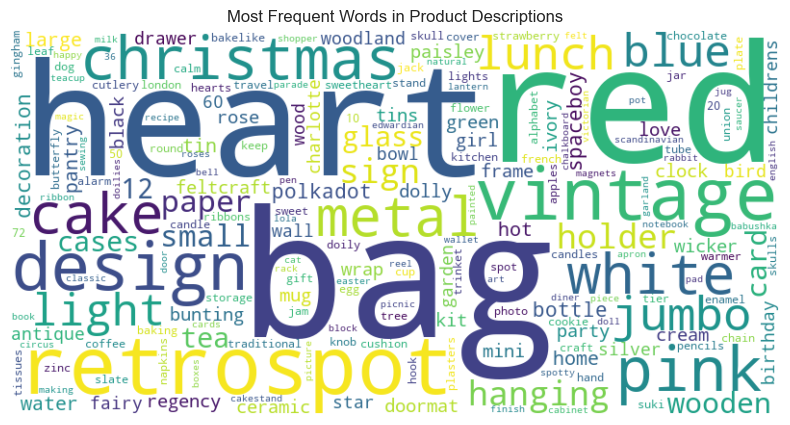

In [101]:
# Creating a word cloud for visualization
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_freq))

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Product Descriptions")
plt.show()


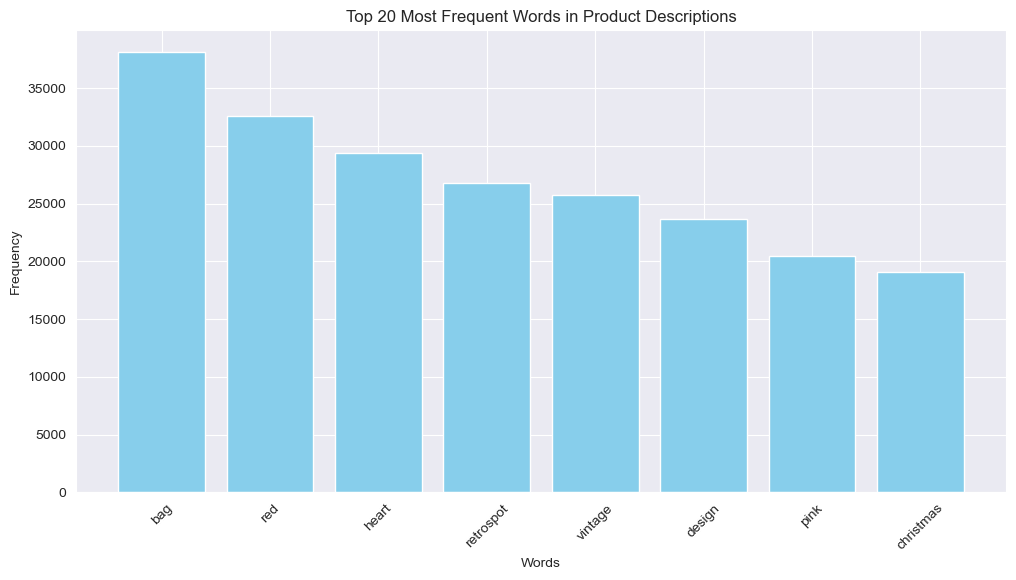

In [102]:
# Selecting the top 8 most frequent words
top_words = word_freq[:8]
words, counts = zip(*top_words)

# Plotting the bar chart
plt.figure(figsize=(12, 6))
plt.bar(words, counts, color='skyblue')
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Words in Product Descriptions")
plt.xticks(rotation=45)
plt.show()


In [103]:
# Defining the top words to look for in descriptions

top_words = ['bag', 'red', 'heart', 'retrospot', 'vintage', 'design', 'pink', 'christmas']
# Initializing binary columns for each top word in the original data
for word in top_words:
    data[word] = data['Description'].str.contains(word, case=False, na=False).astype(int)

# Aggregating to customer level by taking the maximum for each word column
# If a customer has bought any product with that word, the value will be 1
word_features = data.groupby('CustomerID')[top_words].max().reset_index()

# Merging these features back into the customer_data DataFrame
customer_data = customer_data.merge(word_features, on='CustomerID', how='left')

# Displaying the first few rows to verify
customer_data.head()


,CustomerID,PurchaseFrequency,TotalQuantity,TotalSpending,UniqueProducts,AverageOrderValue,AvgQuantityPerPurchase,ProductVarietyIndex,Region_Asia-Pacific,Region_Europe,Region_North America,Region_Other Regions,bag,red,heart,retrospot,vintage,design,pink,christmas
0,12346.0,2,0,0.00,1,0.000000,0.000000,inf,0,1,0,0,0,0,0,0,0,0,0,0
1,12347.0,7,2458,4310.00,103,615.714286,351.142857,0.041904,0,1,0,0,1,1,1,1,1,1,1,1
2,12348.0,4,2341,1797.24,22,449.310000,585.250000,0.009398,0,1,0,0,0,1,1,1,1,1,1,1
3,12349.0,1,631,1757.55,73,1757.550000,631.000000,0.115689,0,1,0,0,1,1,1,1,1,1,1,1
4,12350.0,1,197,334.40,17,334.400000,197.000000,0.086294,0,1,0,0,1,1,0,1,1,0,1,0


**So, We created total of 20 more columns (new variables showing characteristics of customer purchasing behavior, geographic information and product analysis** 

#### Data Preprocessing

In [104]:
# Extracting column names for standardization:
column_names = customer_data.columns

# Displaying the column names
print("Column Names:", column_names)


Column Names: Index(['CustomerID', 'PurchaseFrequency', 'TotalQuantity', 'TotalSpending',
       'UniqueProducts', 'AverageOrderValue', 'AvgQuantityPerPurchase',
       'ProductVarietyIndex', 'Region_Asia-Pacific', 'Region_Europe',
       'Region_North America', 'Region_Other Regions', 'bag', 'red', 'heart',
       'retrospot', 'vintage', 'design', 'pink', 'christmas'],
      dtype='object')


In [105]:
# Replacing inf and -inf values in ProductVarietyIndex with the column median
# (This ensures that outlier values are handled appropriately)
customer_data['ProductVarietyIndex'] = customer_data['ProductVarietyIndex'].replace([np.inf, -np.inf], np.nan)
customer_data['ProductVarietyIndex'] = customer_data['ProductVarietyIndex'].fillna(customer_data['ProductVarietyIndex'].median())

# Dropping rows with any remaining NaN values in standardizable columns
customer_data = customer_data.dropna(subset=['ProductVarietyIndex'])

# List of columns to standardize (excluding CustomerID and Region one-hot encoded columns)
columns_to_standardize = [
    'PurchaseFrequency', 'TotalQuantity', 'TotalSpending', 'UniqueProducts',
    'AverageOrderValue', 'AvgQuantityPerPurchase', 'ProductVarietyIndex',
    'Region_Asia-Pacific', 'Region_Europe', 'Region_North America', 'Region_Other Regions',
    'bag', 'red', 'heart', 'retrospot', 'vintage', 'design', 'pink', 'christmas'
]

# Initializing the StandardScaler
scaler = StandardScaler()

# Fitting the scaler on the columns to standardize and transforming the data
customer_data[columns_to_standardize] = scaler.fit_transform(customer_data[columns_to_standardize])

# Displaying the first few rows to verify the changes
customer_data.head()


,CustomerID,PurchaseFrequency,TotalQuantity,TotalSpending,UniqueProducts,AverageOrderValue,AvgQuantityPerPurchase,ProductVarietyIndex,Region_Asia-Pacific,Region_Europe,Region_North America,Region_Other Regions,bag,red,heart,retrospot,vintage,design,pink,christmas
0,12346.0,-0.329362,-0.239517,-0.230420,-0.704922,-0.871620,-0.611002,-0.185983,-0.077347,0.112873,-0.042816,-0.064297,-1.192544,-1.782061,-1.739478,-1.437330,-1.549093,-1.396448,-1.406486,-1.077565
1,12347.0,0.206102,0.286544,0.294055,0.489243,0.834839,0.484297,-0.449354,-0.077347,0.112873,-0.042816,-0.064297,0.838544,0.561148,0.574885,0.695734,0.645539,0.716102,0.710992,0.928018
2,12348.0,-0.115176,0.261504,-0.011717,-0.459064,0.373647,1.214533,-0.633238,-0.077347,0.112873,-0.042816,-0.064297,-1.192544,0.561148,0.574885,0.695734,0.645539,0.716102,0.710992,0.928018
3,12349.0,-0.436455,-0.104470,-0.016547,0.138018,3.999448,1.357239,-0.031958,-0.077347,0.112873,-0.042816,-0.064297,0.838544,0.561148,0.574885,0.695734,0.645539,0.716102,0.710992,0.928018
4,12350.0,-0.436455,-0.197355,-0.189727,-0.517602,0.055173,0.003488,-0.198242,-0.077347,0.112873,-0.042816,-0.064297,0.838544,0.561148,-1.739478,0.695734,0.645539,-1.396448,0.710992,-1.077565


#### Principal Component Analysis (PCA) Implementation


Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms a dataset with many correlated variables into a smaller set of uncorrelated variables called principal components, while preserving as much of the dataset's variance as possible. It works by identifying patterns in the data and projecting it onto new axes that capture the maximum variance. For our dataset, PCA simplifies the high-dimensional data (with variables like purchase patterns, regional features, and product preferences) into fewer components that summarize the key information. This makes clustering more effective by reducing noise and redundancy, ensuring the analysis focuses on the most significant patterns in customer behavior.

In [106]:
from sklearn.decomposition import PCA

# Defining the number of components (initially using all components to check variance)
pca = PCA(n_components=len(columns_to_standardize))

# Fitting PCA on the standardized data
pca.fit(customer_data[columns_to_standardize])

# Getting the explained variance ratio for each component
explained_variance = pca.explained_variance_ratio_

# Displaying the explained variance ratios
print("Explained variance by each component:\n", explained_variance)


Explained variance by each component:
 [0.23233811 0.13259395 0.10075422 0.07382241 0.05322182 0.05263747
 0.05054422 0.04727707 0.04093676 0.03738561 0.03199572 0.03157391
 0.02958567 0.02700011 0.02205609 0.01966173 0.01185001 0.00346708
 0.00129806]


**Explanation of output**:

The PCA step is implemented to reduce the dimensionality of the dataset while retaining as much variance as possible. The explained variance ratio output indicates the percentage of total variance captured by each principal component (PC), with the first component capturing 23.23% of the variance, followed by 13.26% for the second, and progressively smaller contributions for subsequent components. This step confirms that the majority of the variance is concentrated in the first few components, while components beyond the sixth or seventh contribute minimal variance. The cumulative variance can be plotted to determine the optimal number of components, typically retaining enough components to explain 80-90% of the total variance or using the "elbow method" to balance dimensionality reduction and variance preservation. By standardizing the data prior to PCA and evaluating the explained variance, the implementation ensures effective dimensionality reduction for clustering.

**Plotting Cumulative Explained Variance**

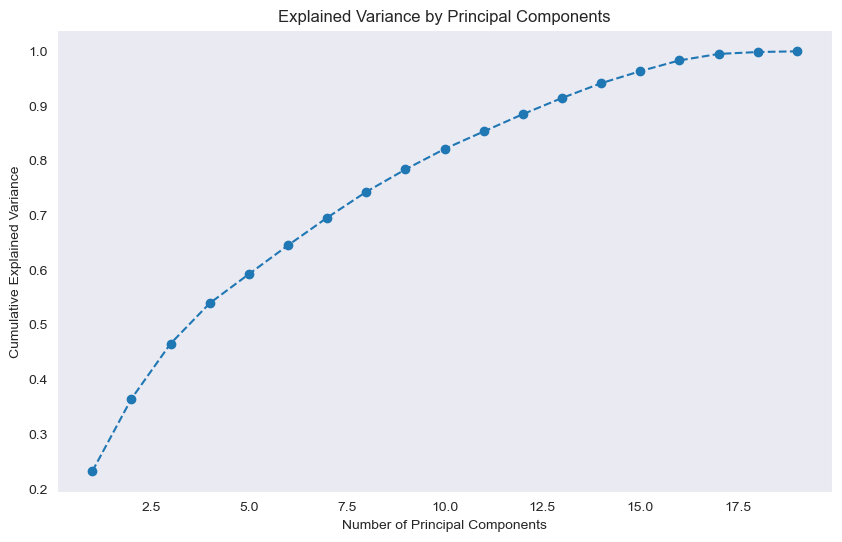

In [107]:

# Calculating cumulative explained variance
cumulative_variance = explained_variance.cumsum()

# Plotting cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid()
plt.show()


**Explanation of the Plot**:

The plot shows the cumulative explained variance as a function of the number of principal components. It helps us determine how many components capture the majority of the dataset's variability. From the plot, we see diminishing returns in variance explained after 15 components.

From the plot, around 12 principal components explain approximately 85% - 90% of the total variance, which is generally a good threshold to retain meaningful information while reducing dimensionality. 

In [108]:
# PCA with 12 components based on the cumulative explained variance
n_components = 12
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(customer_data[columns_to_standardize])

# Creating a DataFrame with the top 25 principal components
pca_data = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

# Adding CustomerID back to the PCA data for reference
pca_data['CustomerID'] = customer_data['CustomerID']

# Displaying the first few rows of the transformed data
pca_data.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,CustomerID
0,-3.873572,1.350419,0.821519,-0.837112,0.037865,0.033591,-0.028062,-0.483433,-0.526194,-0.371331,-0.255286,-0.250004,12346.0
1,2.137422,-0.292075,-0.063695,0.729962,0.173369,-0.220375,-0.462632,0.324460,0.028909,-0.060354,0.005646,0.094773,12347.0
2,1.042002,-0.088337,-0.121287,1.200961,0.146549,-0.225229,-0.439069,0.938197,0.424859,0.532778,0.196465,0.554644,12348.0
3,2.364731,0.354510,-0.570183,3.298272,0.049704,-0.360500,0.329020,0.784422,-0.005698,-0.264281,-0.292245,-0.018986,12349.0
4,-0.466089,-0.248629,-0.214122,0.687091,0.332689,-0.167429,-0.262271,-1.992641,-0.658813,0.023804,-0.518960,1.347442,12350.0


**Scatter Plot of the first two principal components**

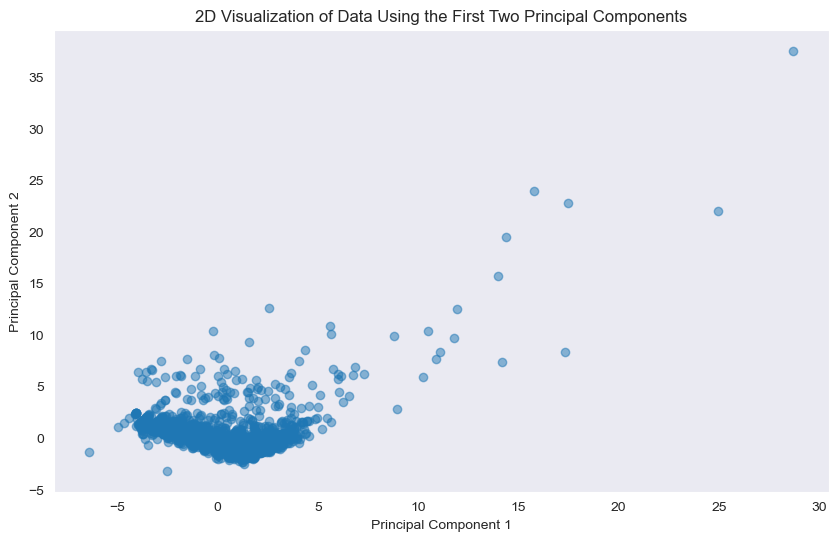

In [109]:
# Scatter plot of the first two principal components
plt.figure(figsize=(10, 6))
plt.scatter(pca_data['PC1'], pca_data['PC2'], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of Data Using the First Two Principal Components')
plt.grid()
plt.show()


Here, the data has a tighter spread near the x-axis, which may imply that the majority of the variance is concentrated along PC1, while PC2 adds less distinctive spread. Most data points form a dense cluster, implying that a large group of customers have similar behaviors or characteristics.  The points further away from the cluster might indicate outliers or unique customer segments.

**Scree Plot of Explained variance by Principal components**

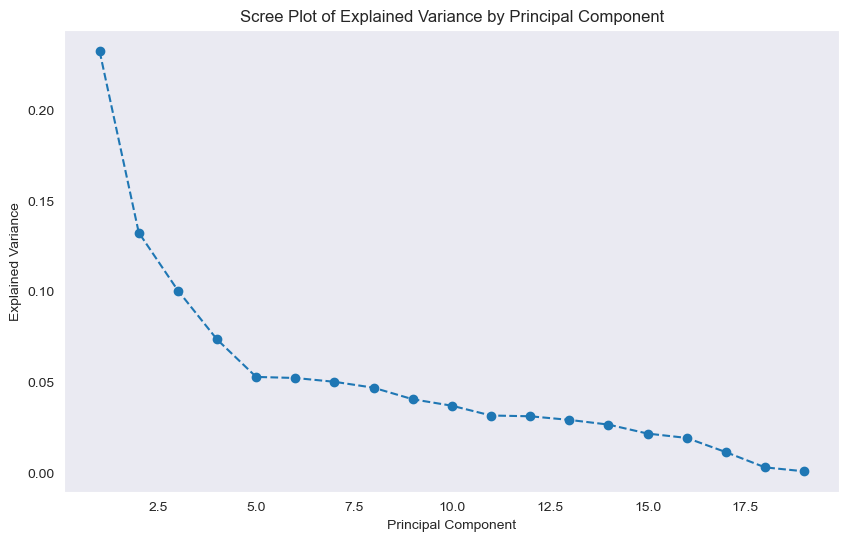

In [110]:
# Scree plot of explained variance by principal components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Scree Plot of Explained Variance by Principal Component')
plt.grid()
plt.show()


**Explanation of the PLot**:

The scree plot illustrates how much variance each principal component explains, with the explained variance decreasing as we move to higher components. For our dataset, the first few components capture a significant portion of the variance, while the contribution from subsequent components diminishes sharply, forming an "elbow" around the 3rd to 5th components. This suggests that most of the dataset's information is contained in the first few components, and we can reduce dimensionality effectively by selecting a subset of components (e.g., the first 10-12) without losing much valuable information. This step simplifies the data for clustering while retaining key patterns.

**Pair Plot of the First Few Principal Components**

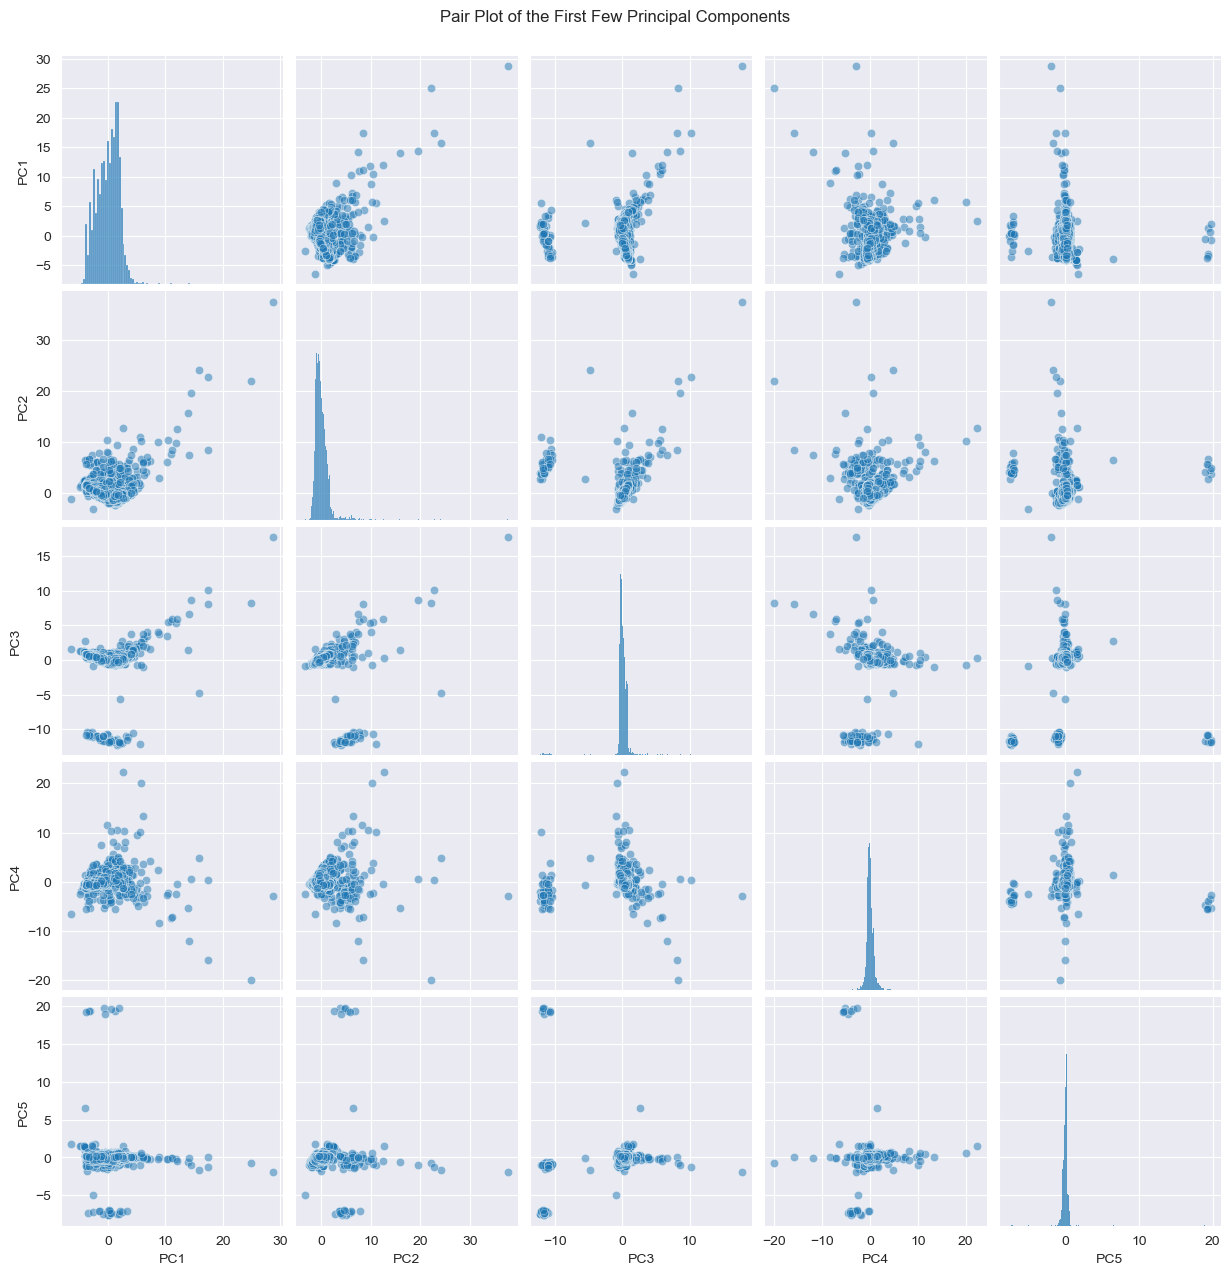

In [111]:

# Selecting the first few principal components
pca_df = pca_data[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']]

# Plotting pairplot for the first few principal components
sns.pairplot(pca_df, plot_kws={'alpha':0.5})
plt.suptitle('Pair Plot of the First Few Principal Components', y=1.02)
plt.show()


The above plot is showing the pairwise relationships among the first 5 components. There are some overlapping and distinct groupings, which could hint at potential clusters or customer patterns.

**Heatmap of Principal Component Loadings**

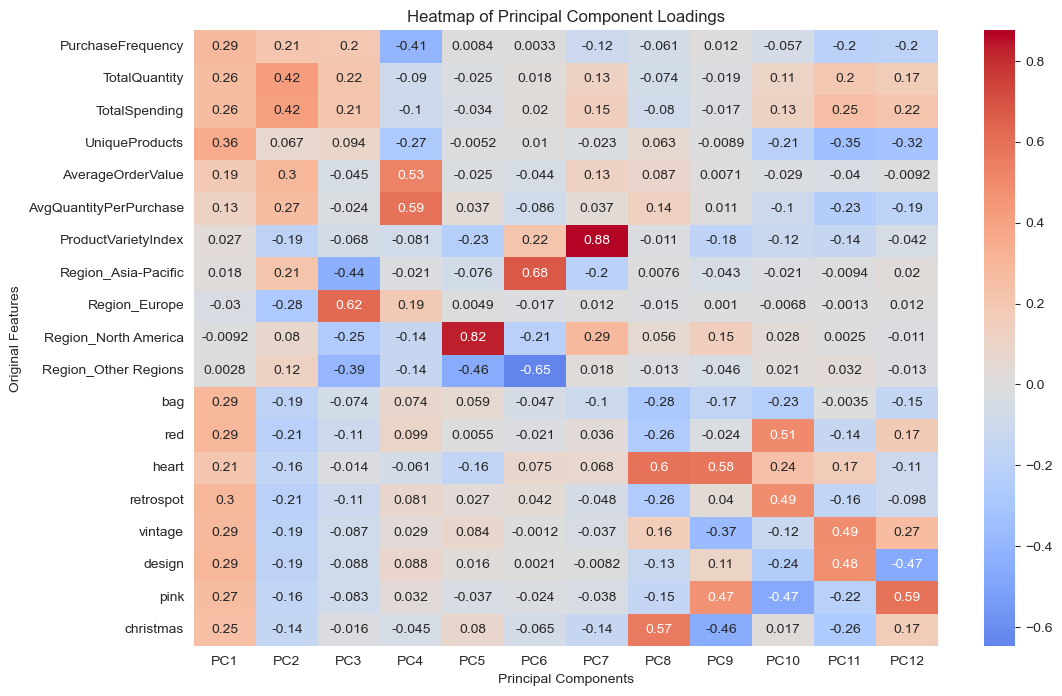

In [112]:
# Loadings are the coefficients that map each feature to the principal components
loadings = pca.components_.T
loading_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(n_components)], index=columns_to_standardize)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(loading_df, annot=True, cmap='coolwarm', center=0)
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.title('Heatmap of Principal Component Loadings')
plt.show()


The above heatmap indicates how much each original feature contributes to each principal component. Specific features (like TotalSpending and PurchaseFrequency) heavily influence some components, helping explain what each component represents.

**Creating the correlation matrix of the principal components**

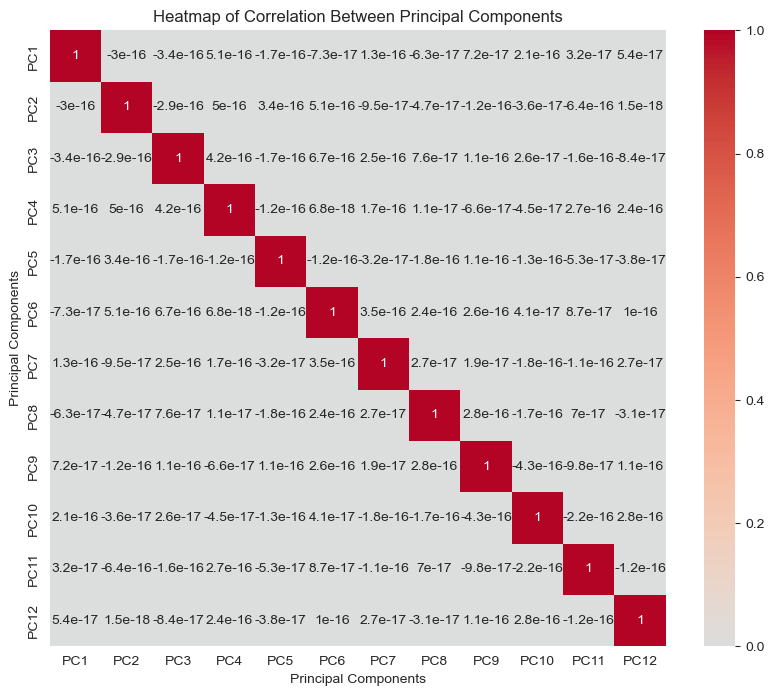

In [113]:
# Creating a DataFrame for the principal components
principal_component_df = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(n_components)])

# Calculating the correlation matrix of the principal components
correlation_matrix = principal_component_df.corr()

# Plotting the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Heatmap of Correlation Between Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Principal Components')
plt.show()


**The above plot shows that the off-diagonal values are near zeroes, confirming that the principal components are uncorrelated.**

**3D Scatter Plot of the First Three Principal Components**

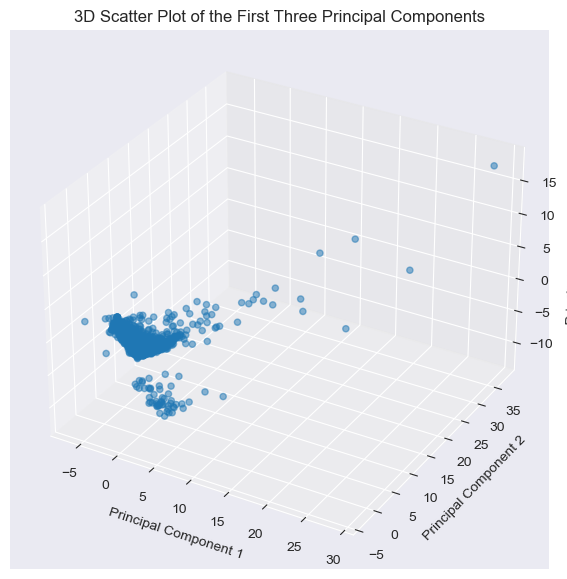

In [114]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_data['PC1'], pca_data['PC2'], pca_data['PC3'], alpha=0.5)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Scatter Plot of the First Three Principal Components')
plt.show()


#### Gaussian Mixture Model For Clustering

Gaussian Mixture Models (GMM) is a probabilistic clustering algorithm that assumes the data is generated from a mixture of several Gaussian distributions, each representing a cluster. Unlike K-Means, which uses hard assignments to classify data points into clusters, GMM employs soft assignments, meaning each data point is assigned a probability of belonging to each cluster. The algorithm works by estimating the parameters (mean, variance, and mixing proportion) of the Gaussian distributions using the Expectation-Maximization (EM) algorithm. In the Expectation step, probabilities (or responsibilities) are calculated for each data point belonging to each cluster. In the Maximization step, these probabilities are used to update the parameters of the Gaussian distributions. The process iterates until convergence, maximizing the likelihood of the data fitting the model. GMM is flexible and can capture clusters of varying shapes and densities, making it suitable for more complex datasets.

In [115]:
# Saving the PCA transformed dataset so that it can be reused later, if needed:
# Saving PCA-transformed data to a CSV file
pca_data.to_csv('pca_transformed_data.csv', index=False)


In [116]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


#### Implementing Gaussian Mixture Model

Choosing the number of clusters and evaluating the GMM using metrics like the Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC)

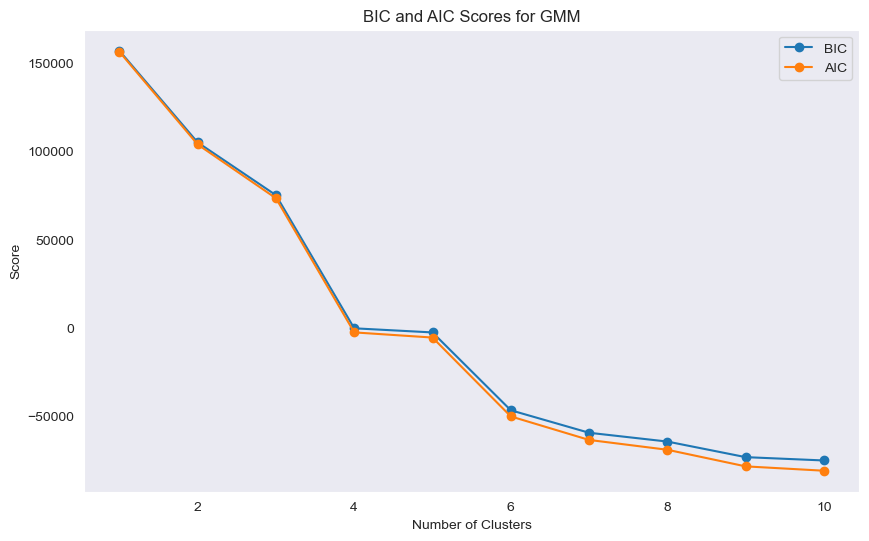

In [117]:
# Defining the range of clusters to evaluate
n_clusters_range = range(1, 11)

# Initializing lists to store BIC and AIC scores
bic_scores = []
aic_scores = []

# Iterating over the range of clusters
for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(pca_data.iloc[:, :-1])  # Excluding 'CustomerID'
    bic_scores.append(gmm.bic(pca_data.iloc[:, :-1]))
    aic_scores.append(gmm.aic(pca_data.iloc[:, :-1]))

# Plotting BIC and AIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, bic_scores, label='BIC', marker='o')
plt.plot(n_clusters_range, aic_scores, label='AIC', marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('BIC and AIC Scores for GMM')
plt.legend()
plt.grid()
plt.show()


**Explanation of BIC and AIC**: 

BIC (Bayesian Information Criterion) and AIC (Akaike Information Criterion) are metrics used to evaluate how well a statistical model fits the data, while also considering the complexity of the model.

**AIC**: AIC measures the goodness of fit of the model and includes a penalty for adding more clusters (complexity). Lower AIC values indicate better-fitting models with less overfitting.


**BIC**: BIC is similar to AIC but adds a heavier penalty for model complexity, making it more conservative in choosing the optimal number of clusters.

Both metrics are calculated based on the likelihood of the data given the model and the number of parameters in the model:

AIC = -2 * (log-likelihood) + 2 * (number of parameters)


BIC = -2 * (log-likelihood) + (number of parameters) * log(n), where n is the number of data points.

The log-likelihood measures how well the model predicts the data, while the penalty term discourages overfitting.

The above plot compares the BIC and AIC scores for a range of clusters (1 to 10). Both scores decrease as the number of clusters increases, indicating an improved model fit.
However, after 4 or 5 clusters, the rate of decrease slows down significantly. This suggests diminishing returns in model improvement for adding more clusters. The elbow point, where the curve flattens, typically represents the optimal balance between model fit and complexity. In this case, the elbow point is observed at 4 or 5 clusters. The optimal number of clusters is likely 4 or 5, as these points balance the trade-off between capturing meaningful segmentation and avoiding overfitting. We will choose 4 clusters as we want to see more detailed understanding of customer segments.

#### Fitting GMM with the Optimal number of Clusters

In [118]:
# Defining the optimal number of clusters (based on BIC/AIC plot)
optimal_clusters = 4

# Fitting GMM
gmm = GaussianMixture(n_components=optimal_clusters,  random_state=42)
gmm.fit(pca_data.iloc[:, :-1])  # Exclude 'CustomerID'

# Predicting cluster labels
pca_data['Cluster'] = gmm.predict(pca_data.iloc[:, :-1])

# Displaying the first few rows with cluster labels
pca_data.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,CustomerID,Cluster
0,-3.873572,1.350419,0.821519,-0.837112,0.037865,0.033591,-0.028062,-0.483433,-0.526194,-0.371331,-0.255286,-0.250004,12346.0,0
1,2.137422,-0.292075,-0.063695,0.729962,0.173369,-0.220375,-0.462632,0.324460,0.028909,-0.060354,0.005646,0.094773,12347.0,3
2,1.042002,-0.088337,-0.121287,1.200961,0.146549,-0.225229,-0.439069,0.938197,0.424859,0.532778,0.196465,0.554644,12348.0,1
3,2.364731,0.354510,-0.570183,3.298272,0.049704,-0.360500,0.329020,0.784422,-0.005698,-0.264281,-0.292245,-0.018986,12349.0,1
4,-0.466089,-0.248629,-0.214122,0.687091,0.332689,-0.167429,-0.262271,-1.992641,-0.658813,0.023804,-0.518960,1.347442,12350.0,0


#### Evaluating Clustering Performance Using Silhouette Score

In [119]:
# Calculating Silhouette Score
silhouette_avg = silhouette_score(pca_data.iloc[:, :-2], pca_data['Cluster'])  # Excluding 'CustomerID' and 'Cluster'
print(f"Silhouette Score for GMM with {optimal_clusters} clusters: {silhouette_avg:.2f}")


Silhouette Score for GMM with 4 clusters: 0.17


**Silhouette Score**

Silhouette Score is a metric used to evaluate the quality of clustering by measuring how well each data point fits within its cluster compared to other clusters. It quantifies how similar a data point is to its own cluster (cohesion) compared to other clusters (separation).

Scores range from -1 to 1:

- A score close to 1 indicates the point is well-clustered.

- A score close to 0 suggests the point lies on the boundary between clusters.

- A score close to -1 means the point is likely in the wrong cluster.

Silhouette Score is calculated as:

For each data point: 

- Calculate the average distance (a) to all the other points in its own cluster (cohesion).
- Calculate the average distance (b) to all points in the nearest neighboring cluster (separation).
- Then, the silhouette score is: S = (b - a) / max(a,b)
- The score is then averaged over the points. 

So, Silhouette Score provides a measure of how distinct and compact the clusters are. Higher scores indicate well-defined clusters, while lower scores suggest overlapping or poorly defined clusters.

**For our Clustering using GMM**: A Silhouette Score of 0.17 indicates that the clustering is moderately defined but not highly distinct, suggesting some overlap between clusters. While this score is not ideal, we believe it will still provide useful insights into customer segmentation. 



#### Visualizing Clusters 

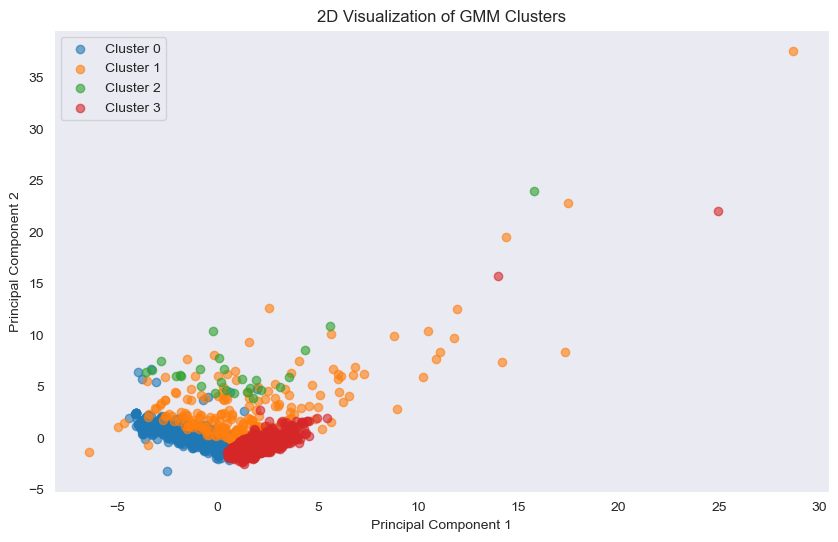

In [120]:
# Visualizing clusters
# Scatter plot of clusters, based on principal component 1 and principal component 2
plt.figure(figsize=(10, 6))
for cluster in range(optimal_clusters):
    cluster_data = pca_data[pca_data['Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.6)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of GMM Clusters')
plt.legend()
plt.grid()
plt.show()


This 2D plot visualizes the GMM clusters based on the top two principal components. Each cluster is represented by a distinct color, showcasing how the data points are distributed and grouped. The clusters appear to have overlapping regions, reflecting the soft clustering nature of GMM. The plot effectively demonstrates the segmentation achieved using Gaussian Mixture Models, highlighting subtle distinctions between customer groups.

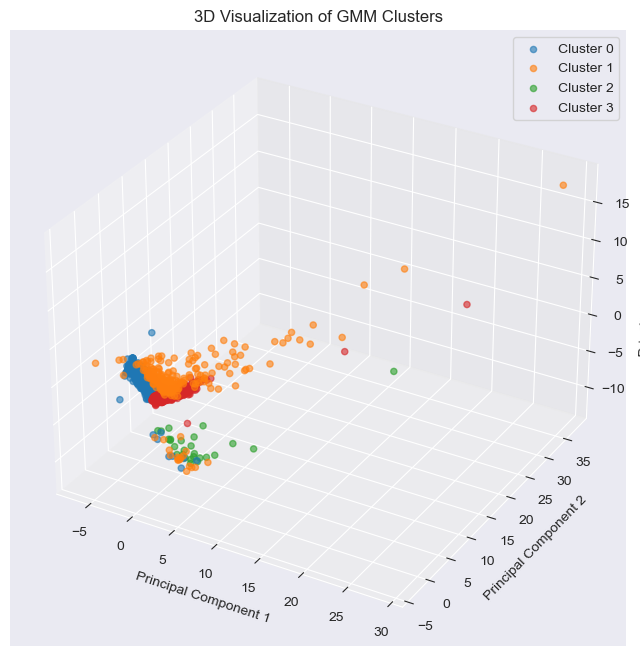

In [121]:
# 3D Visualization using the first three principal components:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(optimal_clusters):
    cluster_data = pca_data[pca_data['Cluster'] == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}', alpha=0.6)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Visualization of GMM Clusters')
ax.legend()
plt.show()


**Making a plot for visualization based on relevant variables in explaining the characteristics of the customers**

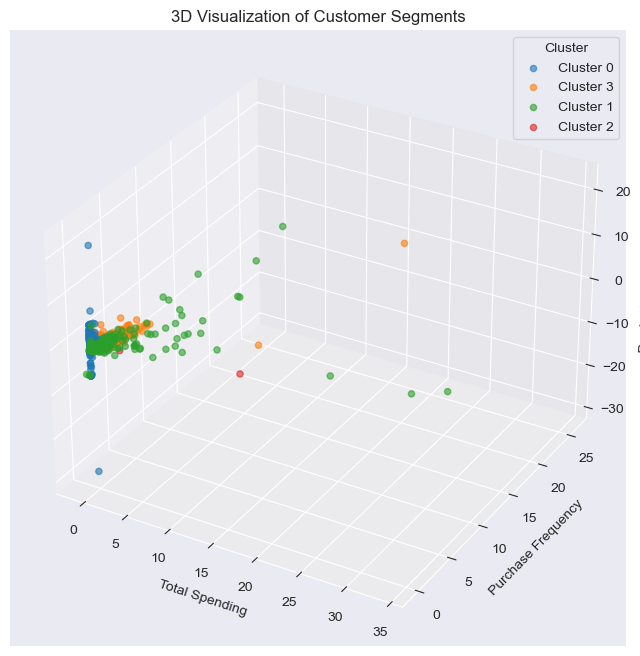

In [122]:
# Merging original features into pca_data
visualization_data = pca_data.merge(customer_data, on='CustomerID')

from mpl_toolkits.mplot3d import Axes3D

# Plotting variables: Total Spending, Purchase Frequency, Product Variety Index
# Defining the data for the 3D plot
x_var = 'TotalSpending'
y_var = 'PurchaseFrequency'
z_var = 'ProductVarietyIndex'

# Creating the 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting each cluster with different colors
for cluster in visualization_data['Cluster'].unique():
    cluster_data = visualization_data[visualization_data['Cluster'] == cluster]
    ax.scatter(cluster_data[x_var], cluster_data[y_var], cluster_data[z_var],
               label=f'Cluster {cluster}', alpha=0.6)

# Adding labels and title
ax.set_xlabel('Total Spending')
ax.set_ylabel('Purchase Frequency')
ax.set_zlabel('Product Variety Index')
ax.set_title('3D Visualization of Customer Segments')
ax.legend(title='Cluster')
plt.show()


The 3D plot effectively visualizes the customer segments formed by the GMM clustering using Total Spending, Purchase Frequency, and Product Variety Index as the axes. The clusters are distinguishable, though some overlap is evident, especially for customers with lower spending and frequency, indicating shared characteristics in these groups. The separation of outlier points (customers with high values in one or more dimensions) provides insight into unique customer behaviors. Overall, the plot highlights key patterns and distinctions among the clusters, though the overlap suggests further refinement or consideration of additional features could improve segmentation clarity.

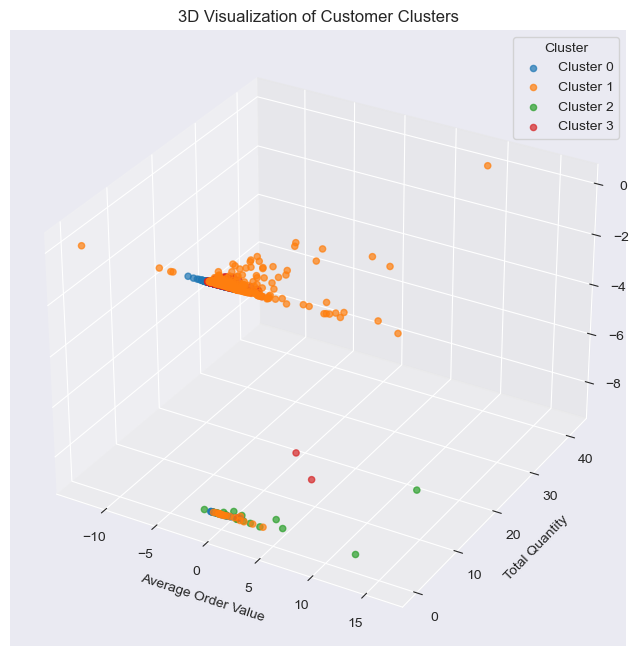

In [123]:
# Now plotting clusters for these variables: spending per order, total quantity purchased, and regional influence

# Creating a 3D plot based on AverageOrderValue, TotalQuantity, and Region_Europe
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Looping through clusters to plot each one
for cluster in sorted(pca_data['Cluster'].unique()):
    cluster_data = customer_data[customer_data['CustomerID'].isin(pca_data[pca_data['Cluster'] == cluster]['CustomerID'])]
    ax.scatter(
        cluster_data['AverageOrderValue'],
        cluster_data['TotalQuantity'],
        cluster_data['Region_Europe'],
        label=f'Cluster {cluster}',
        alpha=0.7
    )

# Setting labels and title
ax.set_xlabel('Average Order Value')
ax.set_ylabel('Total Quantity')
ax.set_zlabel('Region (Europe)')
ax.set_title('3D Visualization of Customer Clusters')
ax.legend(title='Cluster')
plt.show()


This 3D plot visualizes customer clusters using Average Order Value, Total Quantity, and Region (Europe) as the axes. Each cluster is represented by a distinct color, highlighting the segmentation derived from the Gaussian Mixture Model (GMM). The clusters demonstrate some overlap, indicating that while the segmentation captures general patterns, there is not a clear distinction between some customer groups. This suggests moderate differentiation based on these features, and further investigation into additional variables or cluster characteristics may help refine the segmentation.

**Now, we will first identify the top 2 and top 3 most important principal components, then plot clusters based on these principal components, and use these plots to compare the efficiency of clustering between GMM and K-means.** 

In [124]:
 # First Identifying the top 2 and top 3 principal components: 
# Getting the explained variance ratio for all principal components
explained_variance = pca.explained_variance_ratio_

# Sorting the components by their explained variance
top_2_components = sorted(range(len(explained_variance)), key=lambda i: explained_variance[i], reverse=True)[:2]
top_3_components = sorted(range(len(explained_variance)), key=lambda i: explained_variance[i], reverse=True)[:3]

# Mapping the indices to their component names
top_2_components_names = [f'PC{i+1}' for i in top_2_components]
top_3_components_names = [f'PC{i+1}' for i in top_3_components]

# Displaying the results
print("Top 2 Principal Components:", top_2_components_names)
print("Top 3 Principal Components:", top_3_components_names)


Top 2 Principal Components: ['PC1', 'PC2']
Top 3 Principal Components: ['PC1', 'PC2', 'PC3']


**Plotting for GMM the clusters based on top 2 and top 3 principal components**

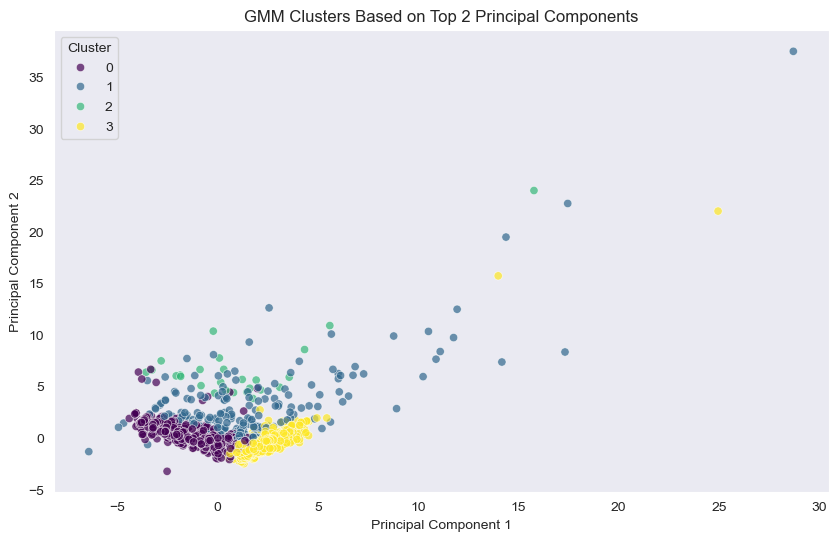

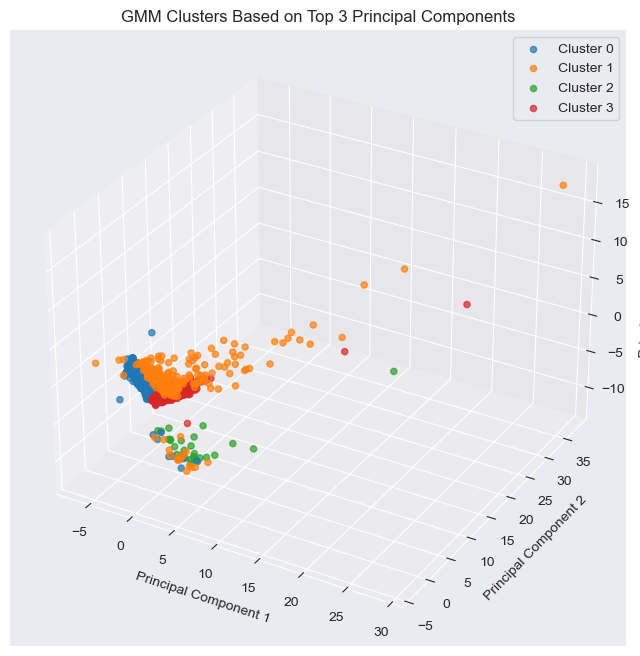

In [125]:
# Plotting Clusters Based on Top 2 Principal Components
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_data,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette='viridis',
    alpha=0.7
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('GMM Clusters Based on Top 2 Principal Components')
plt.legend(title='Cluster')
plt.grid()
plt.show()

# Plotting Clusters Based on Top 3 Principal Components
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot for each cluster
for cluster in sorted(pca_data['Cluster'].unique()):
    cluster_data = pca_data[pca_data['Cluster'] == cluster]
    ax.scatter(
        cluster_data['PC1'],
        cluster_data['PC2'],
        cluster_data['PC3'],
        label=f'Cluster {cluster}',
        alpha=0.7
    )

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('GMM Clusters Based on Top 3 Principal Components')
ax.legend()
plt.show()


**Plot 1**: The graph visualizes the GMM-based clusters using the top two principal components (PC1 and PC2). Each cluster is well-represented in the 2D PCA space, with some overlap but noticeable groupings. The distribution of points highlights the contribution of PC1 and PC2 in separating the clusters. However, the overlap suggests that additional components or variables may better refine cluster distinctions. Overall, it provides a good summary of customer segmentation in the reduced dimensionality space.

**Plot 2**: This 3D plot visualizes the GMM-based clusters using the top three principal components (PC1, PC2, and PC3). It provides a more detailed view of cluster separations compared to the 2D plot, as the addition of PC3 introduces another dimension to distinguish overlapping clusters. While some overlap between clusters still exists, this visualization highlights subtle variations among clusters and offers a richer representation of customer segmentation in the reduced 3D space. It's especially useful for observing the spread and density of data points across multiple dimensions.

#### Defining the 4 clusters based on GMM

**We will define customers based on three major things: Their behavior (like total spending, frequency, etc); Regional information, and, Popular products purchased.**

In [126]:
# Adding the GMM cluster labels to the customer data
customer_data['Cluster'] = pca_data['Cluster']

# 1. Overall summary for each cluster (e.g., spending, frequency, quantity)
cluster_behavior_summary = customer_data.groupby('Cluster').agg({
    'PurchaseFrequency': ['mean', 'median'],
    'TotalSpending': ['mean', 'median'],
    'TotalQuantity': ['mean', 'median'],
    'UniqueProducts': ['mean', 'median'],
    'AverageOrderValue': ['mean', 'median'],
    'AvgQuantityPerPurchase': ['mean', 'median'],
    'ProductVarietyIndex': ['mean', 'median']
}).reset_index()

print("Cluster Behavior Summary:")
print(cluster_behavior_summary)

# 2. Regional distribution for each cluster
cluster_region_summary = customer_data.groupby('Cluster')[
    ['Region_Asia-Pacific', 'Region_Europe', 'Region_North America', 'Region_Other Regions']
].mean().reset_index()

print("\nCluster Region Summary:")
print(cluster_region_summary)

# 3. Popular products in each cluster (based on binary product columns)
popular_products_summary = customer_data.groupby('Cluster')[
    ['bag', 'red', 'heart', 'retrospot', 'vintage', 'design', 'pink', 'christmas']
].mean().reset_index()

print("\nCluster Popular Products Summary:")
print(popular_products_summary)



Cluster Behavior Summary:
  Cluster PurchaseFrequency           TotalSpending           TotalQuantity  \
                       mean    median          mean    median          mean   
0       0         -0.264925 -0.329362     -0.158182 -0.184149     -0.168015   
1       1          1.126611  0.259649      1.096160  0.178700      1.178477   
2       2         -0.041035 -0.329362      0.675577 -0.051901      0.749708   
3       3          0.310147 -0.008083      0.090909 -0.030765      0.093241   

            UniqueProducts           AverageOrderValue            \
     median           mean    median              mean    median   
0 -0.194359      -0.393965 -0.470772         -0.213499 -0.327154   
1  0.222017       0.383384 -0.195645          1.522148  0.764132   
2 -0.107253       0.015990 -0.318574          1.766267  0.472512   
3 -0.028814       0.706832  0.418998          0.098330 -0.070859   

  AvgQuantityPerPurchase           ProductVarietyIndex            
                    mea

#### Cluster Summary Based on GMM

**Cluster 0**: 

**Moderate Buyers from Mixed Regions**

**Characteristics**:

- Moderate purchase frequency and spending.

- High variety in products purchased, with decent average order value.

- Represents regions like Other Regions prominently, with some representation from Europe and North America.

- Popular products: Slight preference for "red" products but generally low popularity for other top words.

**Conclusion: This cluster represents balanced, moderate buyers with diverse purchasing habits.**


**Cluster 1**:

**High Spenders, Focused Buyers**

**Characteristics:**

- High product diversity and significantly high engagement with "bag," "red," "heart," and "design" products.

- Focus on Europe with a slightly positive presence in Asia-Pacific.

- High purchase frequency and total spending compared to other clusters.

**Conclusion: These are focused, high-value customers primarily buying specific trendy products.**


**Cluster 2**:

**Asia-Pacific Bulk Buyers**

**Characteristics:**

- Extremely high total spending and purchase quantity.

- Represented strongly in the Asia-Pacific region.

- Low product diversity but large bulk purchases.

- Less interest in top-word-based products (e.g., "bag," "red," "pink").

**Conclusion: These are bulk buyers from Asia-Pacific, making significant purchases but with low diversity.**


**Cluster 3**:

**Low-Spending, Minimal Buyers**

**Characteristics:**

- Lowest purchase frequency, spending, and product diversity.

- Primarily represented in Europe and Other Regions.

- Low engagement with all top products (e.g., "bag," "red," "heart").

**Conclusion: These are minimal buyers making infrequent, low-value purchases.**



## K-means Clustering 

K-Means is a popular unsupervised learning algorithm used for partitioning data into distinct clusters. The algorithm begins by selecting k random centroids (representing the number of clusters specified). It iteratively assigns each data point to the cluster with the closest centroid, using a distance metric (typically Euclidean distance). Once all data points are assigned, it recalculates the centroids as the mean of all points within each cluster. These steps—assignment and centroid updating—repeat until convergence, which occurs when the centroids stabilize, or a predefined number of iterations is reached. K-Means aims to minimize the total within-cluster variance, making it an efficient tool for segmenting data based on similarity.

In [127]:
# Import necessary libraries for K-Means
from sklearn.cluster import KMeans

In [128]:
#Loading the same PCA-Transformed Data used for GMM
pca_data = pd.read_csv('pca_transformed_data.csv')

In [129]:
# Displaying the first few rows of the loaded PCA-transformed dataset
pca_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,CustomerID
0,-3.873572,1.350419,0.821519,-0.837112,0.037865,0.033591,-0.028062,-0.483433,-0.526194,-0.371331,-0.255286,-0.250004,12346.0
1,2.137422,-0.292075,-0.063695,0.729962,0.173369,-0.220375,-0.462632,0.324460,0.028909,-0.060354,0.005646,0.094773,12347.0
2,1.042002,-0.088337,-0.121287,1.200961,0.146549,-0.225229,-0.439069,0.938197,0.424859,0.532778,0.196465,0.554644,12348.0
3,2.364731,0.354510,-0.570183,3.298272,0.049704,-0.360500,0.329020,0.784422,-0.005698,-0.264281,-0.292245,-0.018986,12349.0
4,-0.466089,-0.248629,-0.214122,0.687091,0.332689,-0.167429,-0.262271,-1.992641,-0.658813,0.023804,-0.518960,1.347442,12350.0


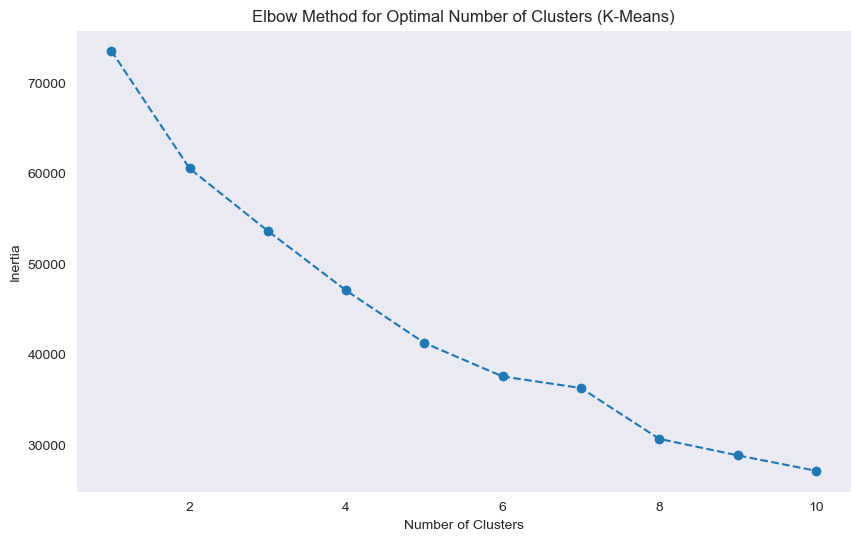

In [130]:
# Determining the Optimal Number of Clusters Using the Elbow Method:
# Defining the range of clusters to evaluate
n_clusters_range = range(1, 11)

# Initializing a list to store inertia values (sum of squared distances to cluster centers)
inertia_scores = []

# Looping through different cluster counts to calculate inertia
for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(pca_data.iloc[:, :-1])  # Exclude 'CustomerID'
    inertia_scores.append(kmeans.inertia_)

# Plotting the inertia scores to identify the elbow point
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, inertia_scores, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters (K-Means)')
plt.grid()
plt.show()

**Elbow Method**:

The Elbow Method is a visual approach used to determine the optimal number of clusters (k) for clustering algorithms such as K-Means. It works by plotting the inertia (within-cluster sum of squared distances to the nearest cluster center) against the number of clusters. As the number of clusters increases, the inertia decreases since data points are assigned to more specific clusters. However, beyond a certain point, adding more clusters results in only a marginal decrease in inertia. The "elbow" in the curve indicates the point where the rate of decrease sharply slows, suggesting the optimal number of clusters. This represents the balance between maximizing explained variance and avoiding overfitting.


Based on the attached elbow method plot, the curve shows a noticeable "elbow" at 6 clusters, as the rate of decrease in inertia significantly diminishes after this point. Choosing 6 clusters is optimal because it balances minimizing within-cluster variance and keeping the model simple, ensuring meaningful segmentation of the data without overcomplicating the clustering structure. However, as we are interested in the comparison between GMM and K-means, we will be choosing 4 clusters for k-means as well. 

In [131]:
# Fitting K-means with the Optimal Number of Clusters:
# Define the optimal number of clusters based on the elbow method
optimal_clusters_kmeans = 4

# Fit K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters_kmeans, random_state=42, n_init=10)
pca_data['KMeans_Cluster'] = kmeans.fit_predict(pca_data.iloc[:, :-1])  # Exclude 'CustomerID'

# Display the first few rows with K-Means cluster labels
pca_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,CustomerID,KMeans_Cluster
0,-3.873572,1.350419,0.821519,-0.837112,0.037865,0.033591,-0.028062,-0.483433,-0.526194,-0.371331,-0.255286,-0.250004,12346.0,1
1,2.137422,-0.292075,-0.063695,0.729962,0.173369,-0.220375,-0.462632,0.324460,0.028909,-0.060354,0.005646,0.094773,12347.0,0
2,1.042002,-0.088337,-0.121287,1.200961,0.146549,-0.225229,-0.439069,0.938197,0.424859,0.532778,0.196465,0.554644,12348.0,0
3,2.364731,0.354510,-0.570183,3.298272,0.049704,-0.360500,0.329020,0.784422,-0.005698,-0.264281,-0.292245,-0.018986,12349.0,0
4,-0.466089,-0.248629,-0.214122,0.687091,0.332689,-0.167429,-0.262271,-1.992641,-0.658813,0.023804,-0.518960,1.347442,12350.0,0


In [132]:
# Calculating Silhouette Score for K-means:
silhouette_avg_kmeans = silhouette_score(pca_data.iloc[:, :-2], pca_data['KMeans_Cluster'])  # Exclude 'CustomerID' and 'KMeans_Cluster'
print(f"Silhouette Score for K-Means with {optimal_clusters_kmeans} clusters: {silhouette_avg_kmeans:.2f}")


Silhouette Score for K-Means with 4 clusters: 0.30


The silhouette score for K-Means (0.30) is higher than GMM (0.17), indicating that K-Means achieves better-defined and more distinct clusters compared to GMM for 4 clusters in our dataset.

#### Plotting Clusters based on K-means for Top 2 Principal Components 

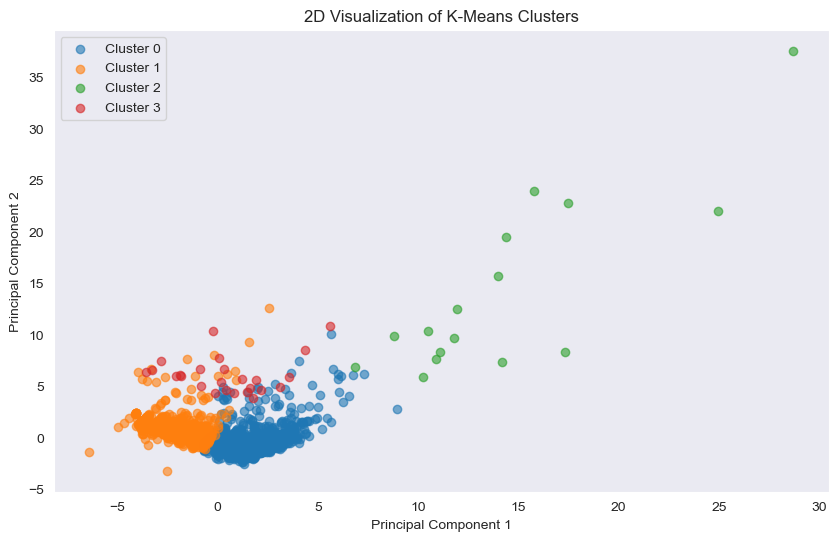

In [133]:
# Visualizing K-means Clusters (2D)
# Scatter plot of clusters for K-Means
plt.figure(figsize=(10, 6))
for cluster in range(optimal_clusters_kmeans):
    cluster_data = pca_data[pca_data['KMeans_Cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}', alpha=0.6)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization of K-Means Clusters')
plt.legend()
plt.grid()
plt.show()

The 2D plot of K-Means clusters based on the top 2 principal components shows a clear separation between the 4 clusters (Cluster 0, Cluster 1, Cluster 2, Cluster 3). Compared to GMM, the boundaries here are more rigid and distinct due to K-Means' reliance on centroids and spherical cluster boundaries. While the clustering appears well-defined, overlapping areas may indicate shared similarities among customer segments, which is inherent to the PCA representation. Overall, this plot provides an effective visual representation of K-Means clustering for customer segmentation.

#### Plotting Clusters based on K-means of Top 3 Principal Components 

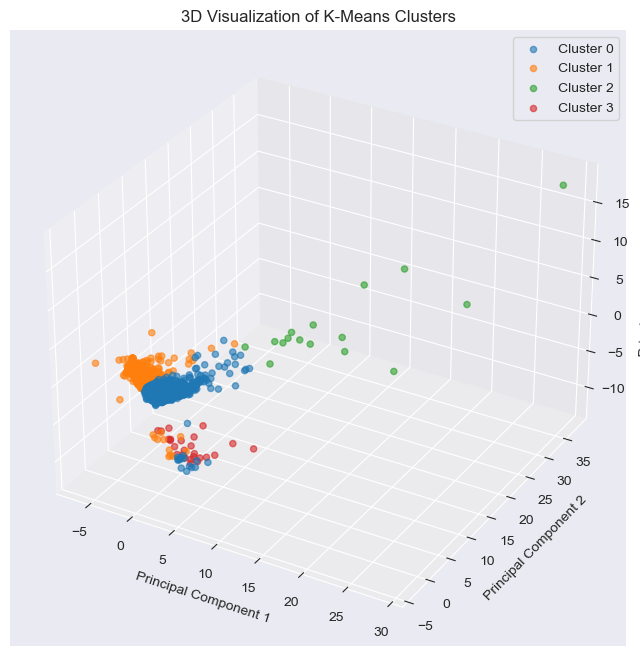

In [134]:
# Visualizing k-means Clusters (3D)
# 3D Visualization using the first three principal components
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in range(optimal_clusters_kmeans):
    cluster_data = pca_data[pca_data['KMeans_Cluster'] == cluster]
    ax.scatter(cluster_data['PC1'], cluster_data['PC2'], cluster_data['PC3'], label=f'Cluster {cluster}', alpha=0.6)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Visualization of K-Means Clusters')
ax.legend()
plt.show()

The 3D plot of K-Means clusters based on the top 3 principal components provides a more comprehensive view of the clustering structure compared to the 2D plot. The additional dimension allows us to observe how clusters separate or overlap in higher-dimensional space. Cluster 0 and Cluster 1 appear more concentrated, indicating tighter customer groupings, while Clusters 2 and 3 show wider dispersions, suggesting greater variability within these segments. This plot effectively highlights the distinctions among clusters while emphasizing the importance of the third principal component in capturing additional variance in the data. Overall, the plot underscores the utility of K-Means in partitioning customers into distinct segments.

#### Cluster Characteristics

In [136]:
# Analyzing Cluster Characteristics:
# Creating a new DataFrame by merging KMeans cluster labels into customer_data
customer_data_with_kmeans_clusters = customer_data.copy()

# Adding the KMeans_Cluster column from pca_data to customer_data_with_kmeans_clusters
customer_data_with_kmeans_clusters['Cluster'] = pca_data['KMeans_Cluster'].values

# Calculating summary statistics for each cluster
cluster_behavior_summary = customer_data_with_kmeans_clusters.groupby('Cluster').agg({
    'PurchaseFrequency': ['mean', 'median'],
    'TotalSpending': ['mean', 'median'],
    'TotalQuantity': ['mean', 'median'],
    'UniqueProducts': ['mean', 'median'],
    'AverageOrderValue': ['mean', 'median'],
    'AvgQuantityPerPurchase': ['mean', 'median'],
    'ProductVarietyIndex': ['mean', 'median']
}).reset_index()

# Region distribution for each cluster
region_summary = customer_data_with_kmeans_clusters.groupby('Cluster').agg({
    'Region_Asia-Pacific': 'mean',
    'Region_Europe': 'mean',
    'Region_North America': 'mean',
    'Region_Other Regions': 'mean'
}).reset_index()

# Popular product words for each cluster
product_summary = customer_data_with_kmeans_clusters.groupby('Cluster').agg({
    'bag': 'mean', 'red': 'mean', 'heart': 'mean', 'retrospot': 'mean',
    'vintage': 'mean', 'design': 'mean', 'pink': 'mean', 'christmas': 'mean'
}).reset_index()

# Displaying summaries for further analysis
print("Cluster Behavior Summary:")
print(cluster_behavior_summary)

print("\nCluster Region Summary:")
print(region_summary)

print("\nCluster Popular Products Summary:")
print(product_summary)



Cluster Behavior Summary:
  Cluster PurchaseFrequency           TotalSpending           TotalQuantity  \
                       mean    median          mean    median          mean   
0       0          0.143335 -0.115176      0.030986 -0.096940      0.031394   
1       1         -0.310972 -0.436455     -0.167882 -0.194614     -0.168331   
2       2          9.195214  6.310398     12.359616  7.593043     12.310574   
3       3         -0.132311 -0.329362      0.109582 -0.065965      0.128024   

             UniqueProducts           AverageOrderValue            \
      median           mean    median              mean    median   
0  -0.099548       0.299469  0.032651          0.108204 -0.105136   
1  -0.207842      -0.540203 -0.564432         -0.228246 -0.388453   
2  12.059033       7.514474  6.348846          4.000488  3.022772   
3  -0.133363      -0.162630 -0.353697          1.344234  0.412818   

  AvgQuantityPerPurchase           ProductVarietyIndex            
                 

#### Cluster Summary

**Cluster 0**

**Low-Spending Generalists**

**Characteristics:**

- Below-average purchase frequency, total spending, and total quantity.

- Fewer unique products purchased.

- Average order value is low.

- Region Distribution: Slightly higher representation in Europe and North America.

- Popular Products: None of the product categories show notable popularity, with most showing below-average engagement.


**Cluster 1:**

**High-Spending Specialists**

**Characteristics:**

- Highest purchase frequency, total spending, and total quantity.

- Moderate number of unique products purchased.

- Highest average order value.

- Region Distribution: Strong representation in "Other Regions."

- Popular Products: Moderate interest in red-themed, design, and vintage products.


**Cluster 2**:

**Medium-Spending Asian Shoppers**

**Characteristics:**

- Moderate total spending and total quantity but low purchase frequency.

- Low variety in unique products purchased.

- High average order value.

- Region Distribution: Dominantly represented in Asia-Pacific regions, with very little presence elsewhere.

- Popular Products: Slight preference for retrospot-themed products but low engagement overall.

**Cluster 3**:

**Product-Focused Enthusiasts**

**Characteristics:**

- Slightly higher-than-average purchase frequency but low total spending and total quantity.

- High engagement with unique products.

- Low average order value.

- Region Distribution: Uniform representation across regions.

- Popular Products: Significant interest in bag, heart, design, and pink-themed products.

#### Comparison of customer segmentation between: "PCA with GMM" vs. "PCA with K-Means"

**1. Silhouette Scores:**

**GMM**: 0.17 - Indicates overlapping clusters with less distinct boundaries.

**K-Means**: 0.30 - Indicates moderately distinct clustering, significantly better than GMM.

**Winner: K-Means**

**2. Clustering Visualization (Top 2 Principal Components):**

**GMM**: The clusters appeared to overlap significantly, with poor separation between groups. Some clusters were scattered or mixed, making it harder to interpret boundaries.

**K-Means**: The clusters were more distinct and clearly separated. Better-defined groupings were visible, indicating more meaningful segmentation.

**Winner: K-Means**

**3. Clustering visualization (Top 3 Principal Components):**

**GMM**: Clusters were still overlapping in 3D, showing poor separation. The spread across principal components indicated some ambiguity in cluster assignments.

**K-Means**: Clusters remained well-separated and distinct in 3D. K-Means showed tighter and more organized clusters compared to GMM.

**Winner: K-Means**

**4. Cluster Characteristics:**

**GMM**: Clusters were moderately differentiated by spending patterns, product preferences, and regional affiliations. Overlapping clusters made it harder to assign clear-cut characteristics.

**K-Means**: Clusters were more distinct with unique characteristics for each group. Better separation in regional distribution and product preferences made it easier to define customer personas.

**Winner: K-Means**

**5. Overall Performance**:

**GMM**: Struggled with overlapping clusters, making customer segmentation less actionable.

**K-Means**: Delivered distinct and actionable clusters with better visual and statistical validation.

**Final Verdict:**

**K-Means performed significantly better than GMM for customer segmentation after PCA. The higher silhouette score, better visualization (clear separation of clusters), and distinct cluster characteristics make K-Means the more suitable method for our dataset.**

#### Citations of python code libraries used for their standard code:

PCA: https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.PCA.html

GMM: https://scikit-learn.org/dev/modules/generated/sklearn.mixture.GaussianMixture.html

K-means: https://scikit-learn.org/1.5/modules/generated/sklearn.cluster.KMeans.html